# EXPERIMENT 2
---
### Model Architecture: LSTM
### Dataset: Milan

### Parameters
- INPUT_DIM = 1000 (chosen arbitary, high dimension)
- N_HIDDEN = 64
- MAX_LENGTH = 2000 (fixed)
- NO_ACTIVITIES = 8 (cairo fixed)
- OPTIMIZER = ADAM
- TOTAL EPOCHS = 50


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#imports
import os 
import pickle
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#tensorflow
import tensorflow as tf
from keras.layers import Dense, LSTM, Bidirectional, RNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential
DATA_PATH = '/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/PP_Data/'

Mounted at /content/drive/


In [ ]:
def getData(datasetName):
    X = np.load(f"{DATA_PATH}{datasetName}_X.npy", allow_pickle=True)
    Y = np.load(f"{DATA_PATH}{datasetName}_Y.npy", allow_pickle=True)
    enc_dec = np.load(f"{DATA_PATH}/{datasetName}_ENCDEC.npy", allow_pickle=True)
    return X, Y, enc_dec
X, y, (idx2act, idx2obs, act2idx, obs2idx) = getData('milan')

In [ ]:
def get_class_acc(X, y, model, idx2act):
  preds = np.array(np.argmax(model.predict(X, verbose=1), axis=-1), dtype=np.int32)
  targets = np.array(y, dtype=np.int32)
  
  print("Classwise accuracy: ")
  totals = {}
  correct = {}
  for i in range(len(idx2act)):
    totals[i] = 1
    correct[i] = 0
  for each in targets: 
    totals[each]+=1
  for i in range(len(idx2act)):
    if totals[i] != 1:
      totals[i] -= 1
  for i, each in enumerate(preds): 
    if each == targets[i]:
        correct[each]+=1
  for i, each in enumerate(idx2act):
    print(f"Model accuracy for predicting {each}: {correct[i]}/{totals[i]} || {round(correct[i]/totals[i]*100, 2)}%")

  print('-'*120)
  m = confusion_matrix(targets, preds)
  fig, ax = plt.subplots(figsize=(23,20))
  sns.heatmap(m, annot=True, ax=ax)
  ax.set(xticklabels=idx2act, yticklabels=idx2act)
  plt.show()
  print('-'*120)

In [ ]:
def plot_history(dict):
  # summarize history for accuracy
  plt.figure(figsize=(10,10))
  plt.plot(dict['accuracy'])
  plt.plot(dict['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(10,10))
  plt.plot(dict['loss'])
  plt.plot(dict['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

In [ ]:
def run(X, y, idx2act, model, save_as, EPOCHS=10):
  print("-"*100)
  print(" > REPORT")
  print("-"*100)
  # TEST SPLIT
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

  print('Training set distribution')
  fig, ax = plt.subplots(figsize=(20,5))
  train_y_df = pd.DataFrame({'y' : np.array(y_train, dtype=np.float32)})
  sns.countplot(train_y_df.y, ax=ax)
  ax.set(xticklabels=idx2act)
  plt.xticks(rotation=45)
  plt.show()
  print('Test set distribution')
  fig2, ax2 = plt.subplots(figsize=(20,5))
  test_y_df = pd.DataFrame({'y' : np.array(y_test, dtype=np.float32)})
  sns.countplot(test_y_df.y, ax=ax2)
  ax2.set(xticklabels=idx2act)
  plt.xticks(rotation=45)
  plt.show()
  
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)
  
  # KFOLD SETUP
  X_train_np = np.array(X_train, dtype=np.float32)
  y_train_np = np.array(y_train, dtype=np.float32)
  skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
  # KFOLD LOOP
  overall_acc = []
  
  agg_hist={'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
  for i, (train, test) in enumerate(skf.split(X_train_np, y_train_np)):
    print(f'Fold >> {i+1}')
    X_train_ = tf.convert_to_tensor(X_train_np[train], dtype=tf.float32)
    Y_train_ = tf.convert_to_tensor(y_train_np[train], dtype=tf.float32)
    X_test_ = tf.convert_to_tensor(X_train_np[test], dtype=tf.float32)
    Y_test_ = tf.convert_to_tensor(y_train_np[test], dtype=tf.float32)
    print(f"Begin training ...")

    filepath = f"/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/Experiments/Models/{save_as}"
    history = model.fit(X_train_, Y_train_, epochs=EPOCHS, batch_size=64, verbose=1, callbacks=[], validation_split=0.2)
    agg_hist['loss'].extend(history.history['loss'])
    agg_hist['val_loss'].extend(history.history['val_loss'])
    agg_hist['accuracy'].extend(history.history['accuracy'])
    agg_hist['val_accuracy'].extend(history.history['val_accuracy'])
    print(f"Begin evalutaion ...")
    scores = model.evaluate(X_test_, Y_test_, batch_size=64, verbose=1)
    print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
    overall_acc.append(scores[1]*100)
    print()

  model.save(filepath+".h5")
  print('HISTORY')
  plot_history(agg_hist)
  print()

  print('Test set evalutaion')
  scores = model.evaluate(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), batch_size=64, verbose=1)
  print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
  print()
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)

In [ ]:
# biLSTM 
def get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER):
  model = Sequential(name='biLSTM')
  model.add(Embedding(INPUT_DIM, N_HIDDEN, input_length=MAX_LENGTH, mask_zero=True))
  model.add((LSTM(N_HIDDEN)))
  model.add(Dense(NO_ACTIVITIES, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
#Arbitary high dim
INPUT_DIM = 1000 
#2n
N_HIDDEN = 64
MAX_LENGTH = 2000
NO_ACTIVITIES = len(idx2act)
OPTIMIZER = 'adam'

In [ ]:
model = get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER)

Model: "biLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 14)                910       
Total params: 97,934
Trainable params: 97,934
Non-trainable params: 0
_________________________________________________________________


----------------------------------------------------------------------------------------------------
 > REPORT
----------------------------------------------------------------------------------------------------
Training set distribution


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


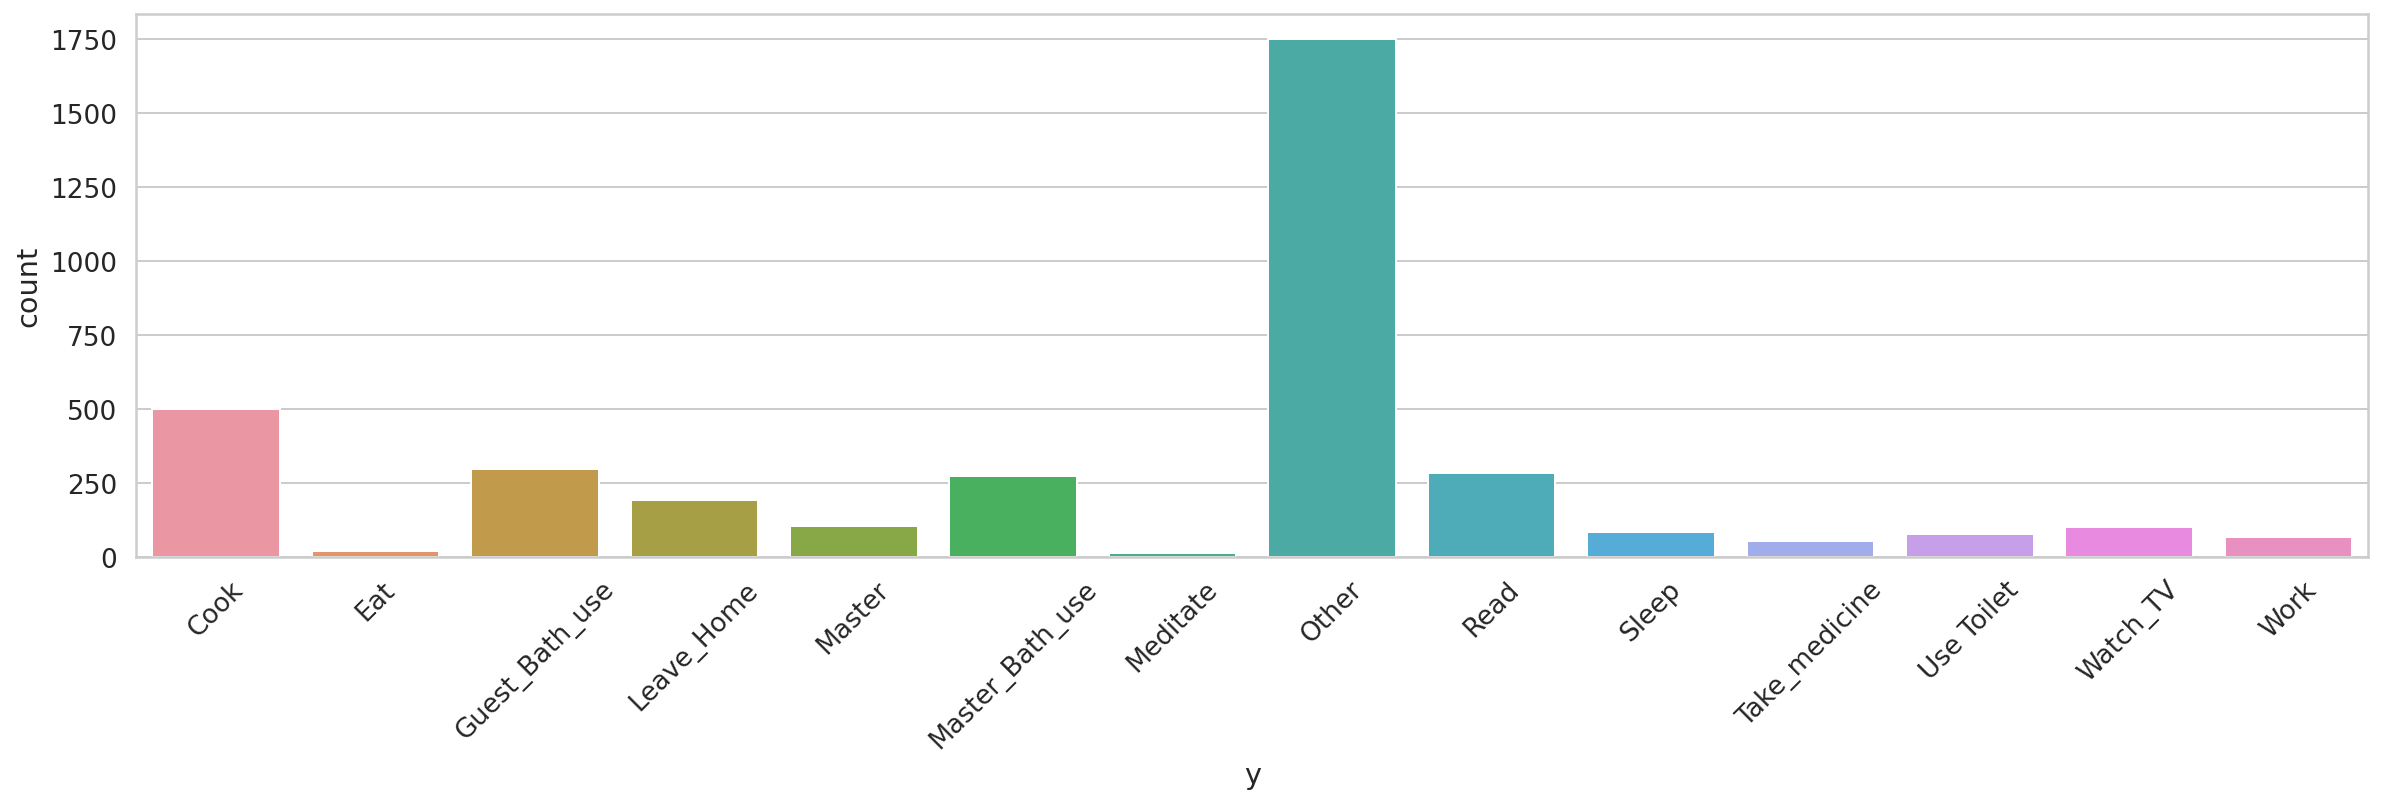

Test set distribution


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


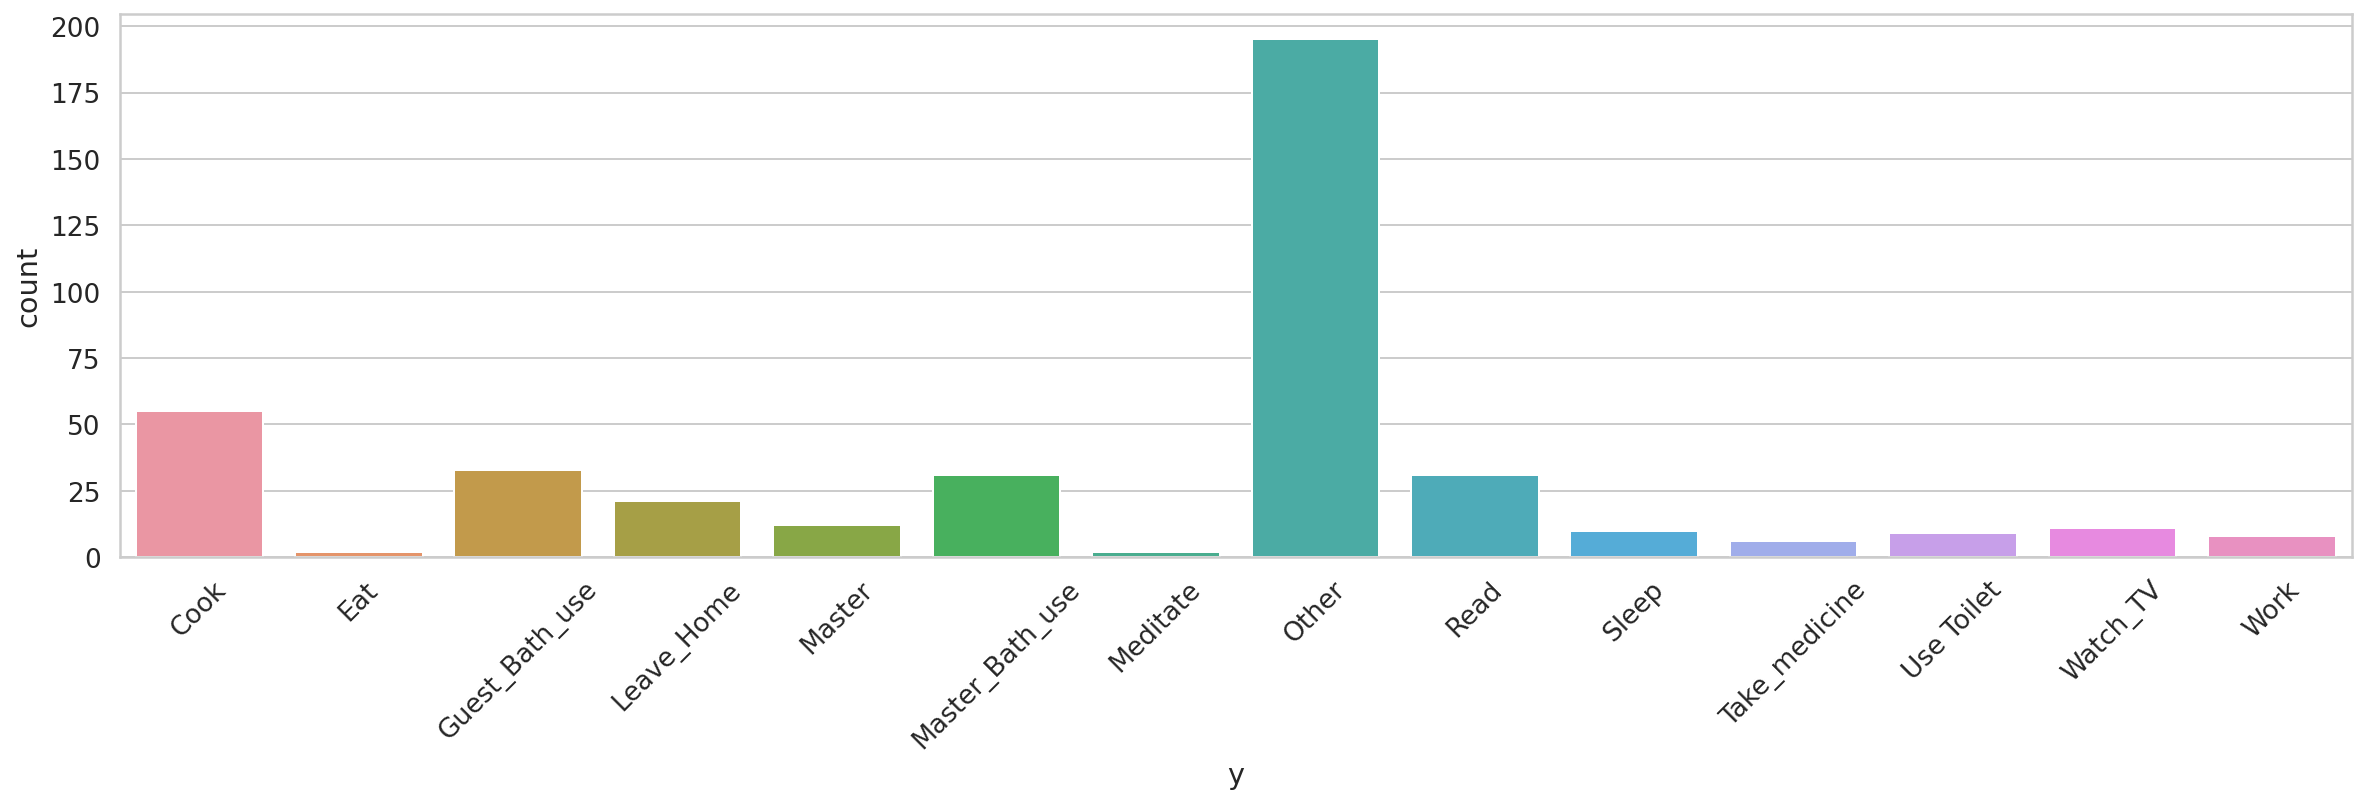

Activity accuracy training set
--------------------------------------------------------------------------------
120/120 [==============================] - 38s 319ms/step
Classwise accuracy: 
Model accuracy for predicting Cook: 0/499 || 0.0%
Model accuracy for predicting Eat: 5/20 || 25.0%
Model accuracy for predicting Guest_Bath_use: 1/297 || 0.34%
Model accuracy for predicting Leave_Home: 66/193 || 34.2%
Model accuracy for predicting Master: 56/105 || 53.33%
Model accuracy for predicting Master_Bath_use: 0/275 || 0.0%
Model accuracy for predicting Meditate: 1/15 || 6.67%
Model accuracy for predicting Other: 216/1748 || 12.36%
Model accuracy for predicting Read: 4/283 || 1.41%
Model accuracy for predicting Sleep: 0/86 || 0.0%
Model accuracy for predicting Take_medicine: 6/54 || 11.11%
Model accuracy for predicting Use Toilet: 5/80 || 6.25%
Model accuracy for predicting Watch_TV: 0/103 || 0.0%
Model accuracy for predicting Work: 0/68 || 0.0%
---------------------------------------------

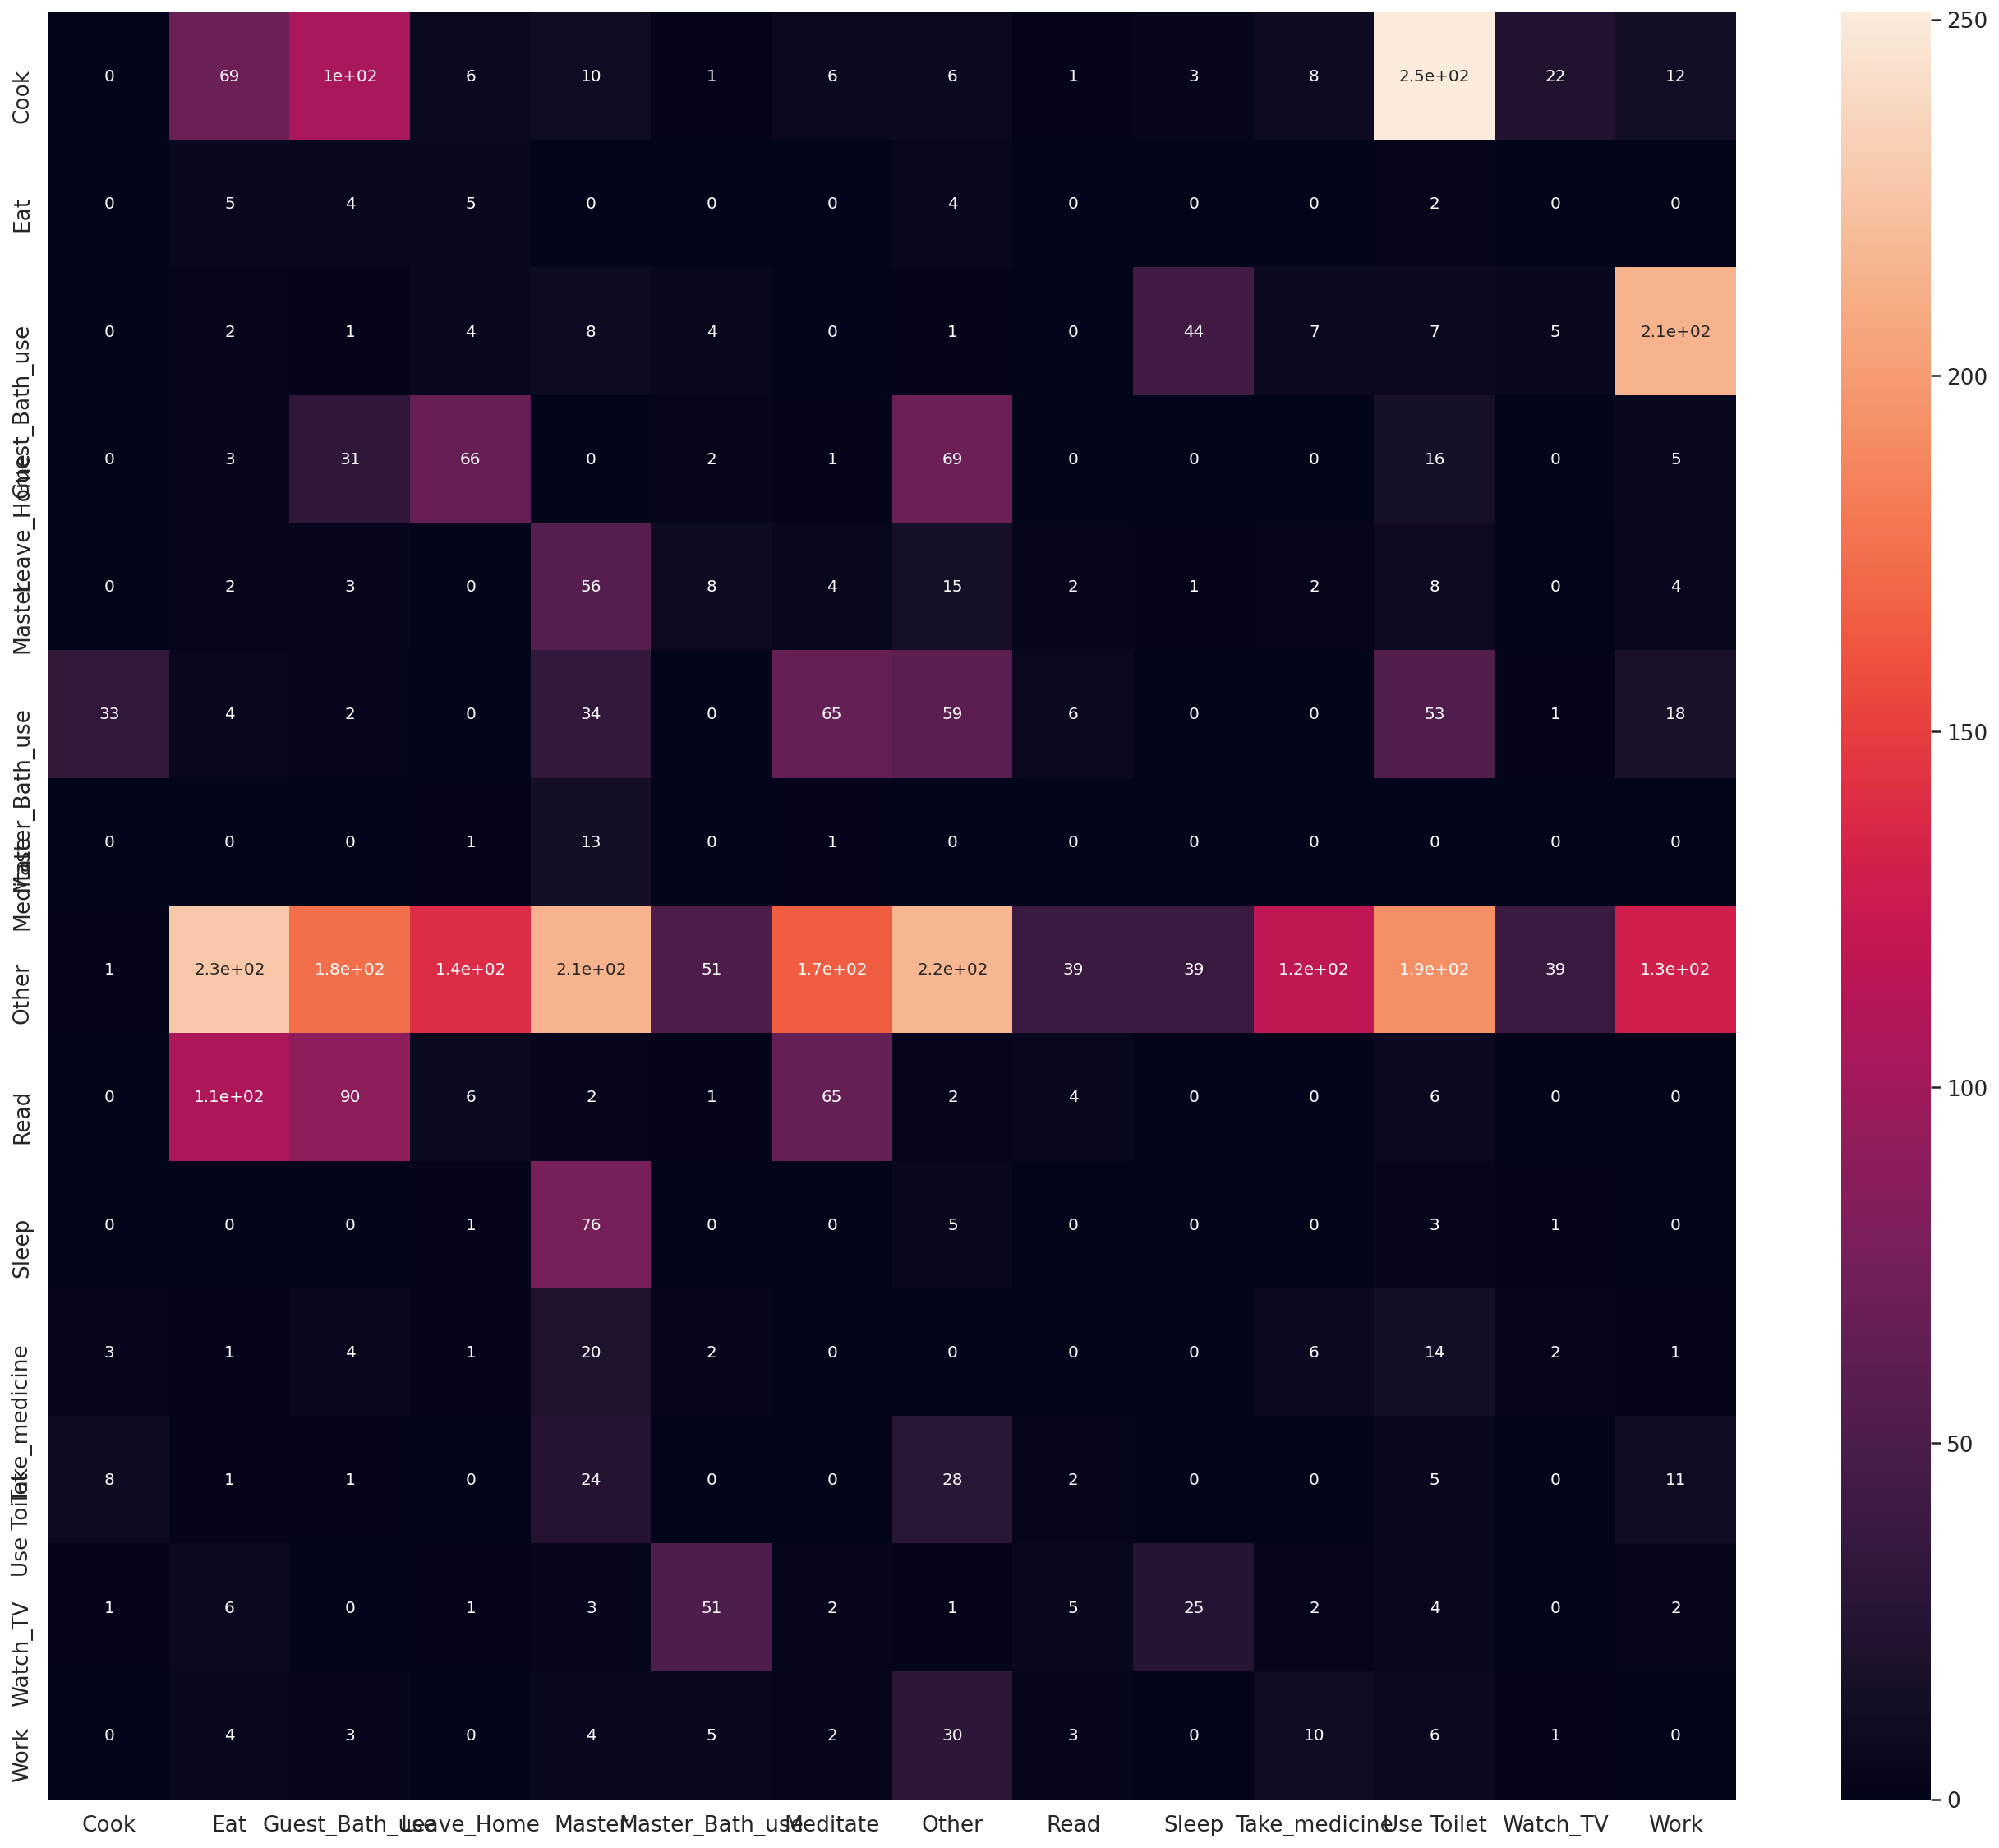

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
14/14 [==============================] - 4s 299ms/step
Classwise accuracy: 
Model accuracy for predicting Cook: 0/55 || 0.0%
Model accuracy for predicting Eat: 1/2 || 50.0%
Model accuracy for predicting Guest_Bath_use: 0/33 || 0.0%
Model accuracy for predicting Leave_Home: 7/21 || 33.33%
Model accuracy for predicting Master: 6/12 || 50.0%
Model accuracy for predicting Master_Bath_use: 0/31 || 0.0%
Model accuracy for predicting Meditate: 2/2 || 100.0%
Model accuracy for predicting Other: 22/195 || 11.28%
Model accuracy for predicting Read: 0/31 || 0.0%
Model accuracy for predicting Sleep: 0/10 || 0.0%
Model accuracy for predicting Take_medicine: 0/6 || 0.0%
Model accuracy for predicting Use Toilet: 0/9 || 0.0%
Model accuracy for predicting Watch_TV: 0/11 || 0.0

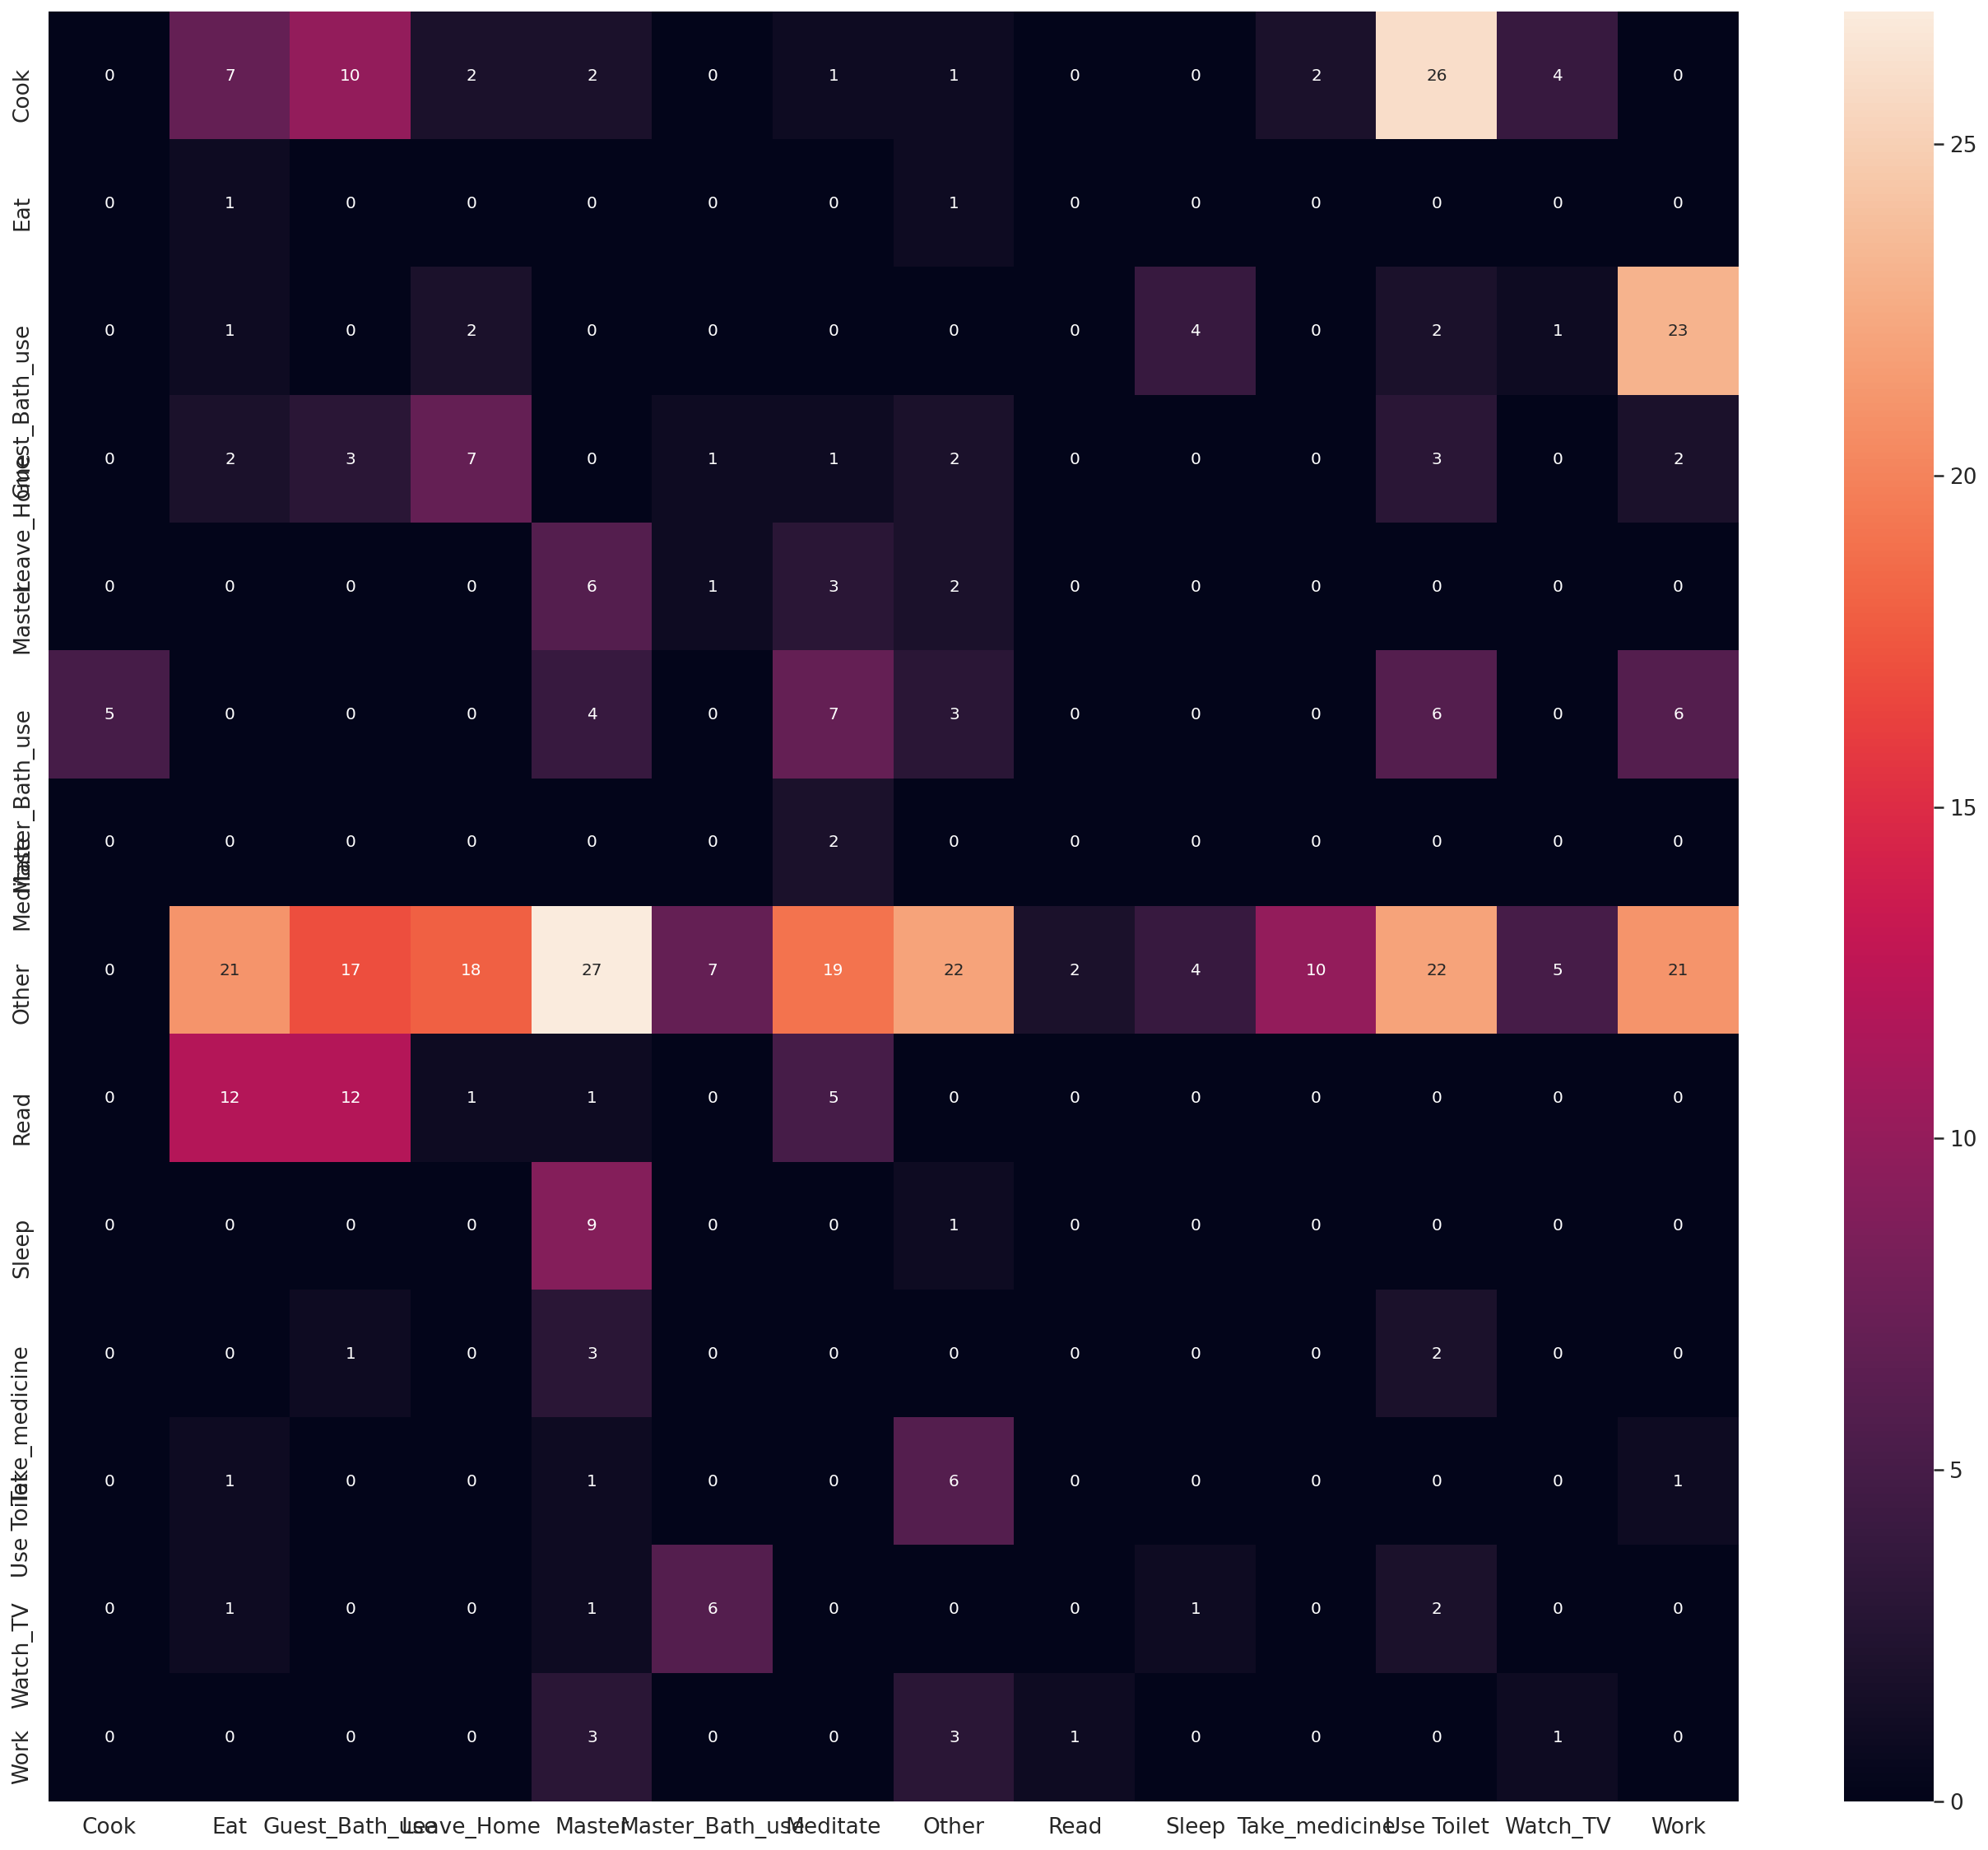

------------------------------------------------------------------------------------------------------------------------
Fold >> 1
Begin training ...
Epoch 1/10
39/39 [==============================] - 168s 4s/step - loss: 2.1624 - accuracy: 0.4641 - val_loss: 1.7196 - val_accuracy: 0.5278
Epoch 2/10
39/39 [==============================] - 164s 4s/step - loss: 1.4099 - accuracy: 0.6507 - val_loss: 1.1341 - val_accuracy: 0.7124
Epoch 3/10
39/39 [==============================] - 166s 4s/step - loss: 0.9903 - accuracy: 0.7316 - val_loss: 0.8660 - val_accuracy: 0.7516
Epoch 4/10
39/39 [==============================] - 165s 4s/step - loss: 0.7942 - accuracy: 0.7774 - val_loss: 0.7036 - val_accuracy: 0.7941
Epoch 5/10
39/39 [==============================] - 164s 4s/step - loss: 0.6997 - accuracy: 0.8015 - val_loss: 0.6579 - val_accuracy: 0.8039
Epoch 6/10
39/39 [==============================] - 163s 4s/step - loss: 0.6681 - accuracy: 0.8084 - val_loss: 0.6223 - val_accuracy: 0.8121
Epoc

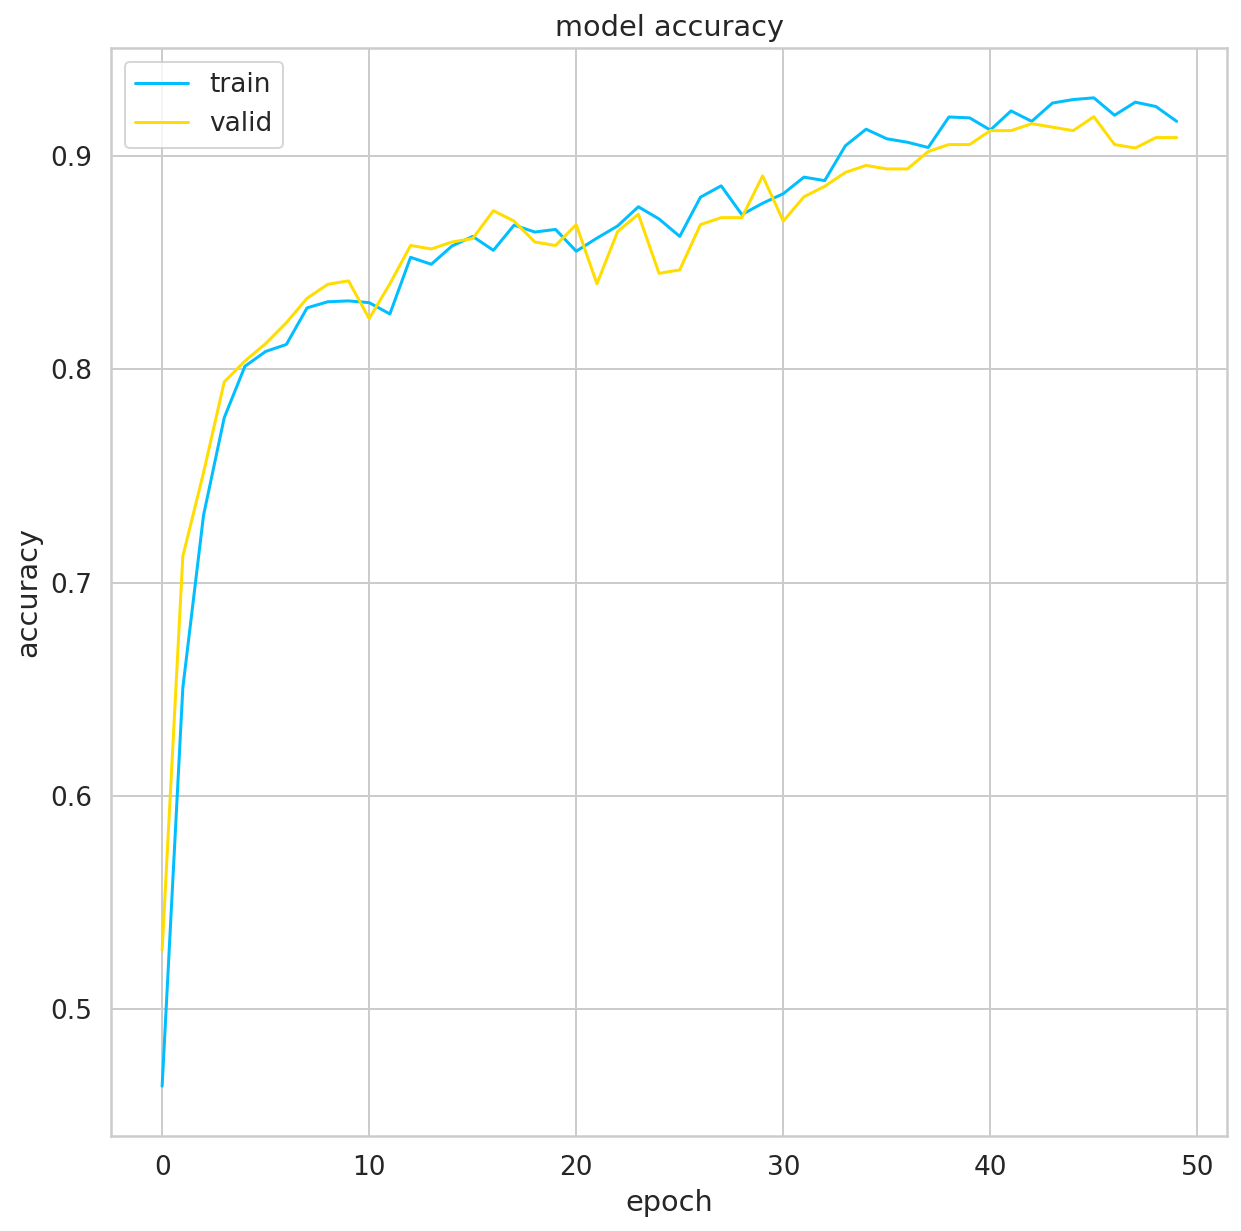

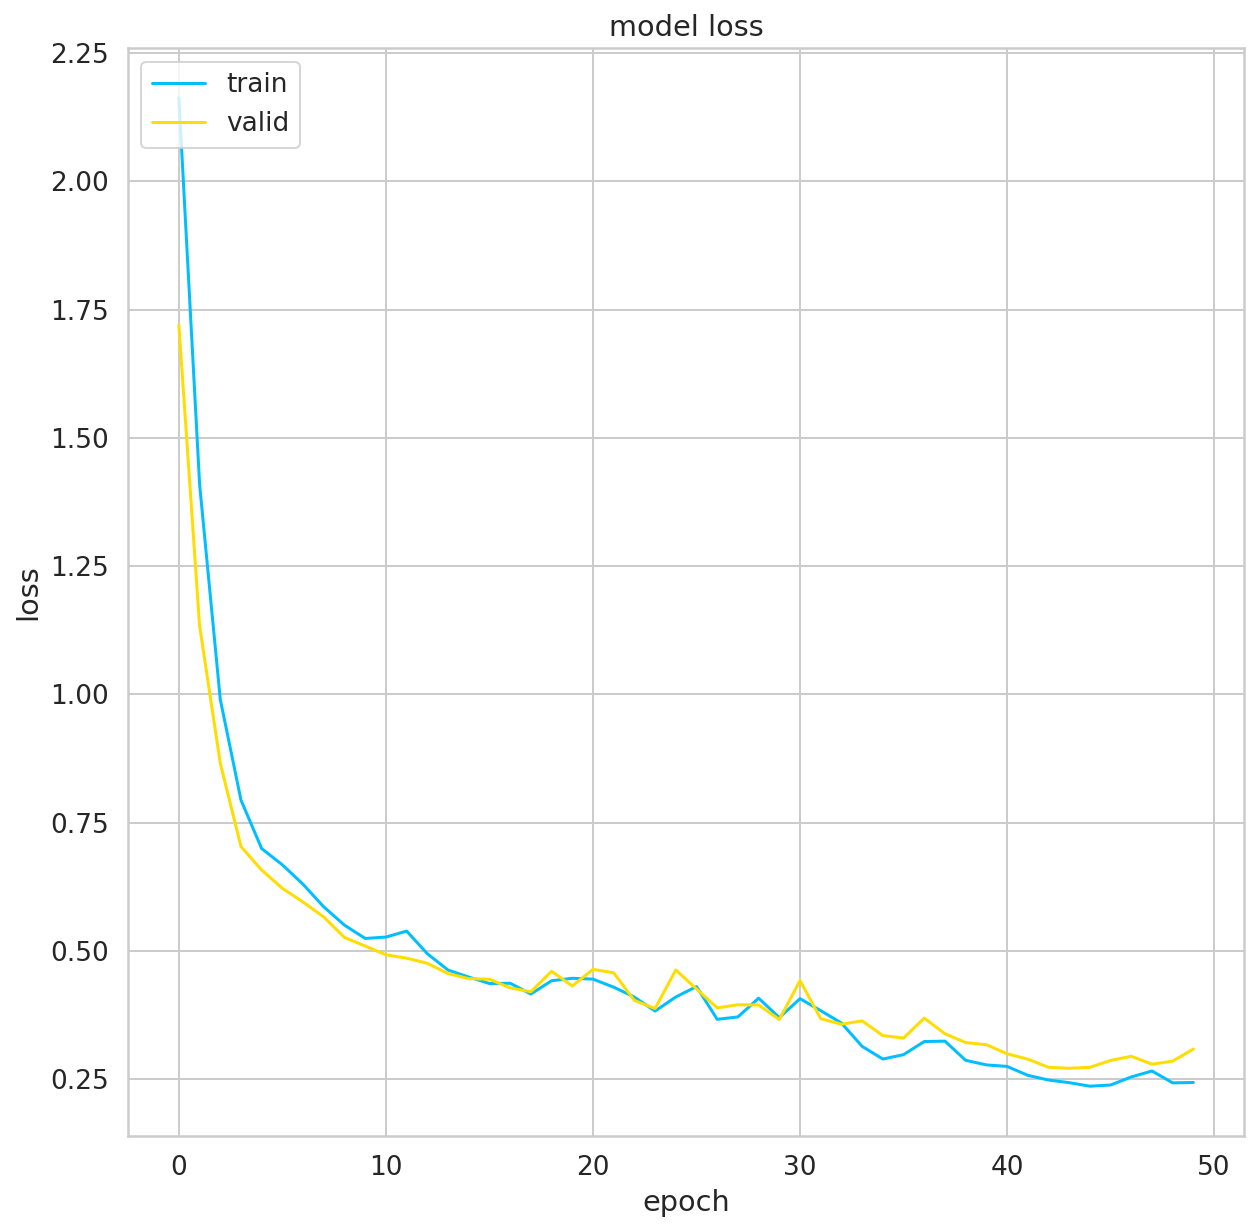


Test set evalutaion
7/7 [==============================] - 2s 273ms/step - loss: 0.3739 - accuracy: 0.8897
accuracy: 88.97%

Activity accuracy training set
--------------------------------------------------------------------------------
120/120 [==============================] - 37s 309ms/step
Classwise accuracy: 
Model accuracy for predicting Cook: 482/499 || 96.59%
Model accuracy for predicting Eat: 0/20 || 0.0%
Model accuracy for predicting Guest_Bath_use: 291/297 || 97.98%
Model accuracy for predicting Leave_Home: 188/193 || 97.41%
Model accuracy for predicting Master: 91/105 || 86.67%
Model accuracy for predicting Master_Bath_use: 271/275 || 98.55%
Model accuracy for predicting Meditate: 14/15 || 93.33%
Model accuracy for predicting Other: 1571/1748 || 89.87%
Model accuracy for predicting Read: 279/283 || 98.59%
Model accuracy for predicting Sleep: 73/86 || 84.88%
Model accuracy for predicting Take_medicine: 47/54 || 87.04%
Model accuracy for predicting Use Toilet: 19/80 || 23.75

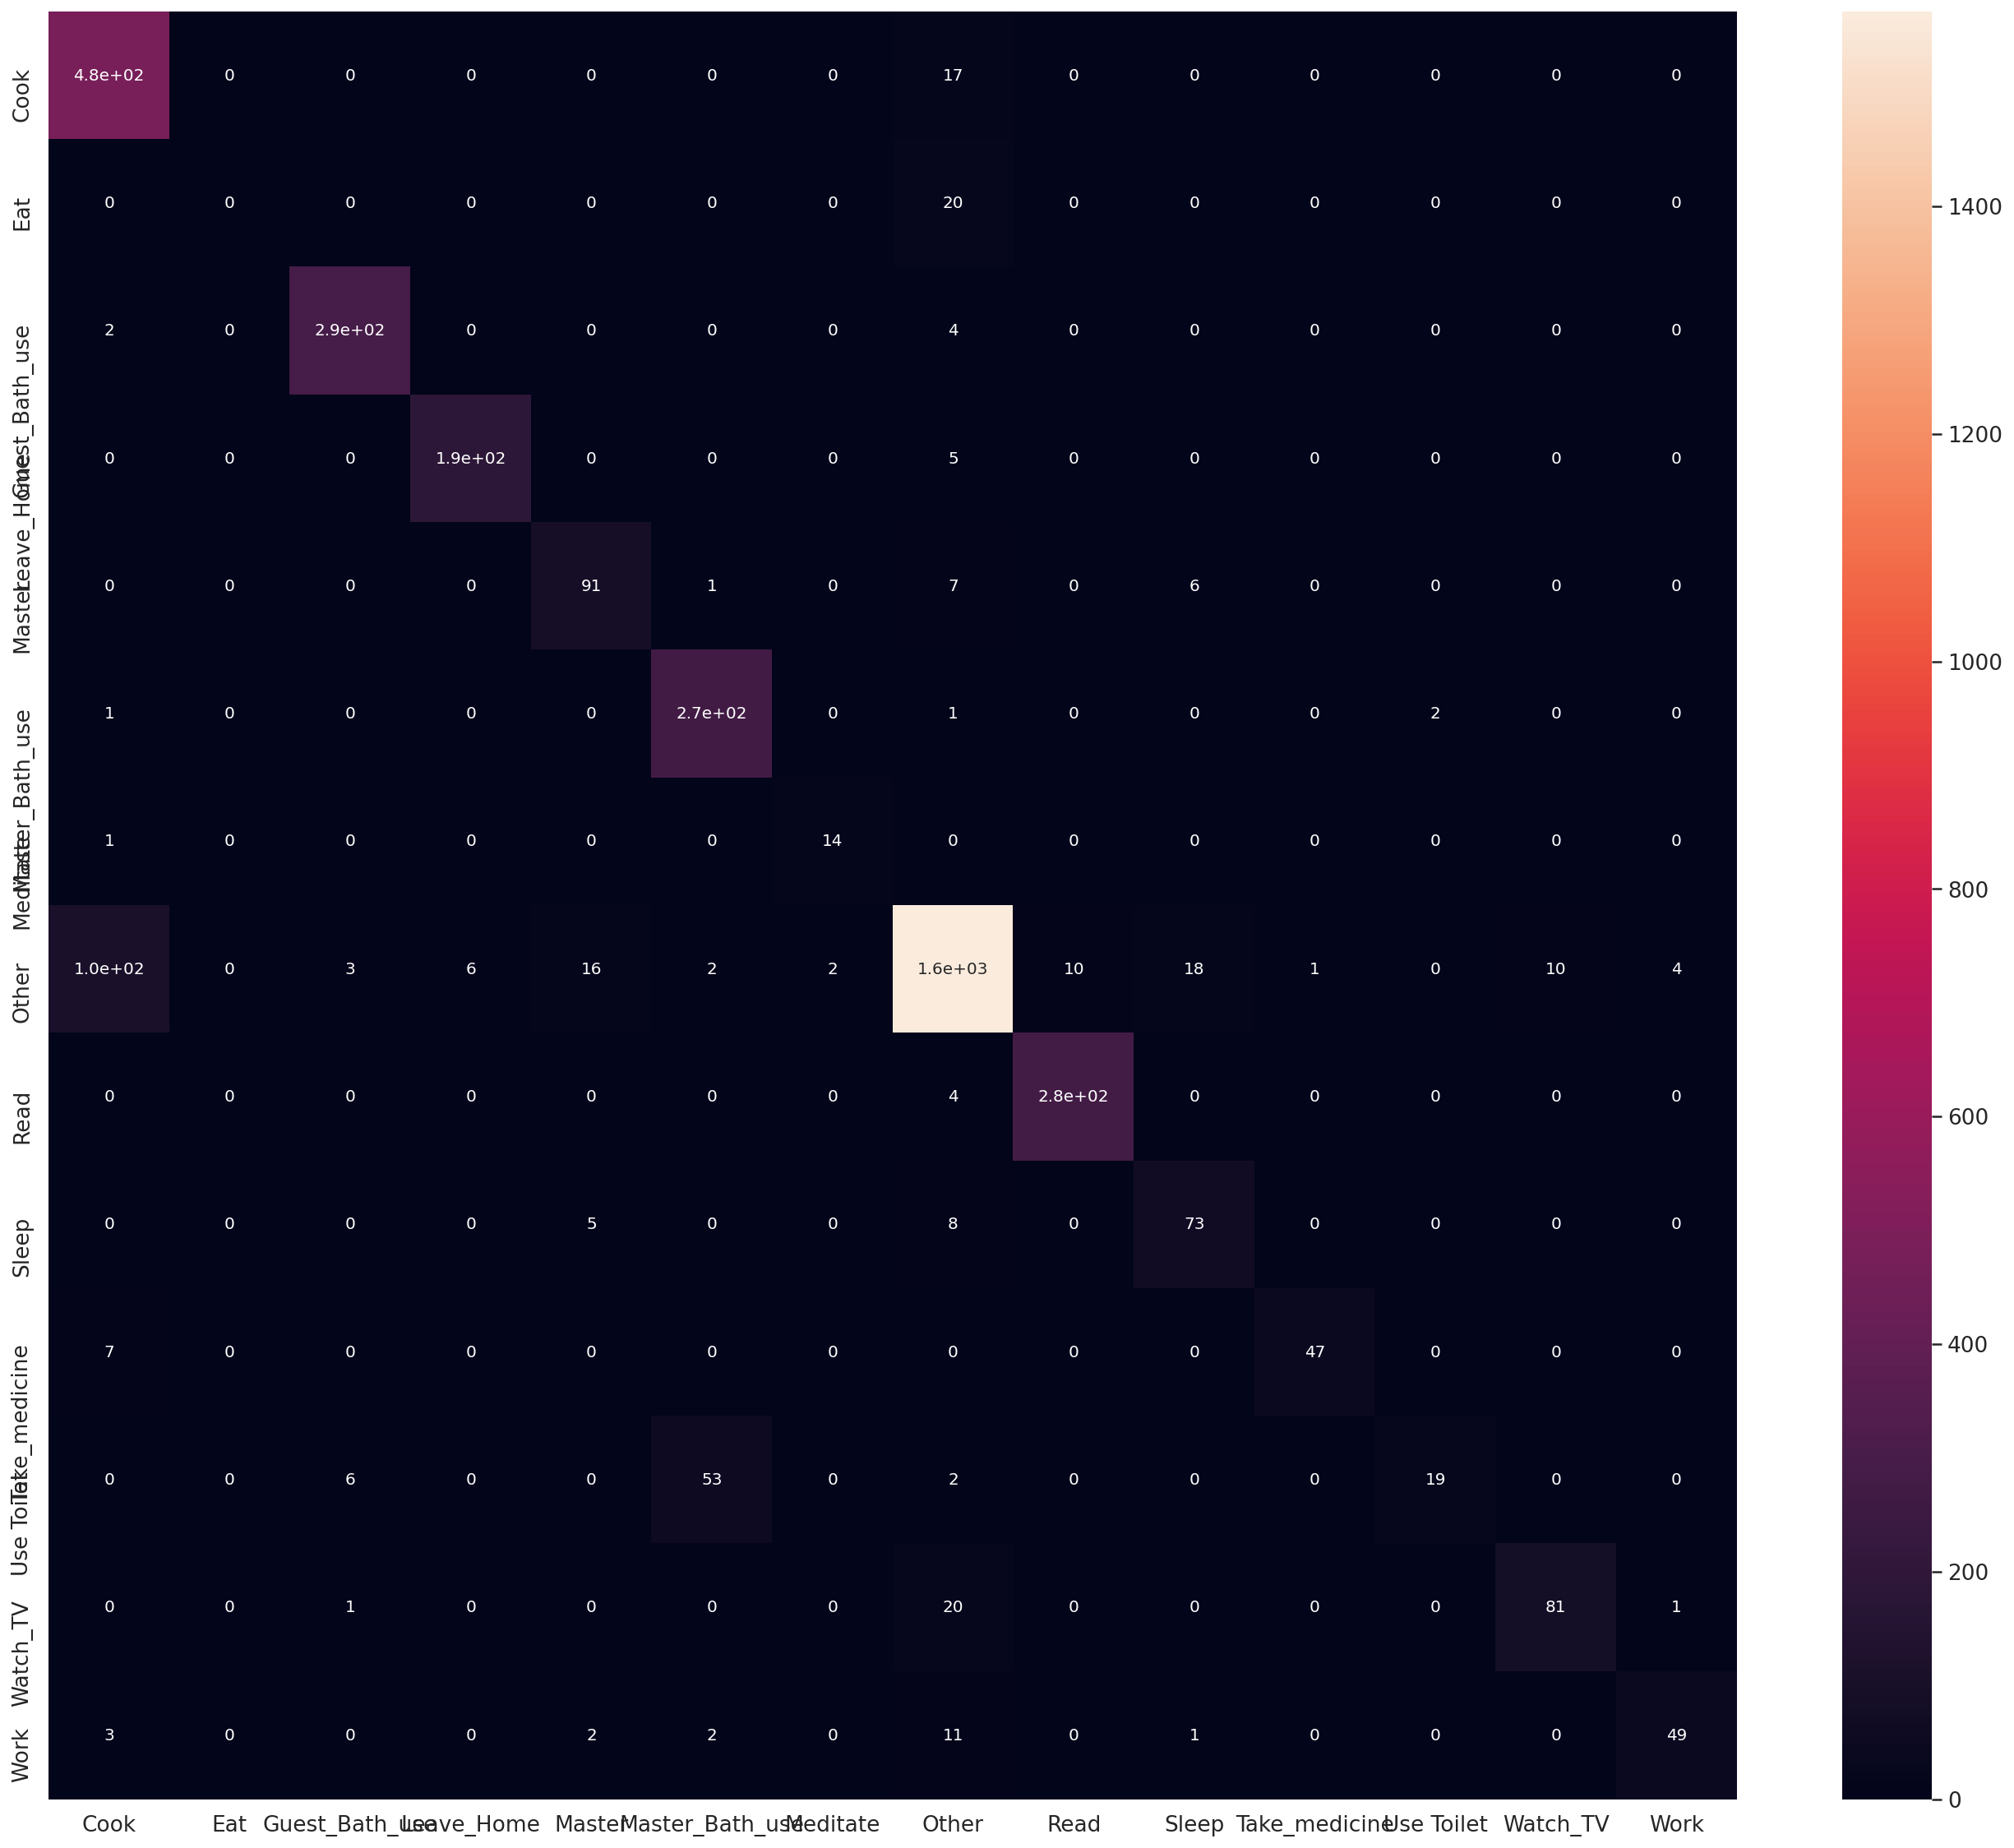

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
14/14 [==============================] - 4s 291ms/step
Classwise accuracy: 
Model accuracy for predicting Cook: 54/55 || 98.18%
Model accuracy for predicting Eat: 0/2 || 0.0%
Model accuracy for predicting Guest_Bath_use: 31/33 || 93.94%
Model accuracy for predicting Leave_Home: 21/21 || 100.0%
Model accuracy for predicting Master: 9/12 || 75.0%
Model accuracy for predicting Master_Bath_use: 28/31 || 90.32%
Model accuracy for predicting Meditate: 2/2 || 100.0%
Model accuracy for predicting Other: 177/195 || 90.77%
Model accuracy for predicting Read: 31/31 || 100.0%
Model accuracy for predicting Sleep: 9/10 || 90.0%
Model accuracy for predicting Take_medicine: 4/6 || 66.67%
Model accuracy for predicting Use Toilet: 2/9 || 22.22%
Model accuracy for predicting Wat

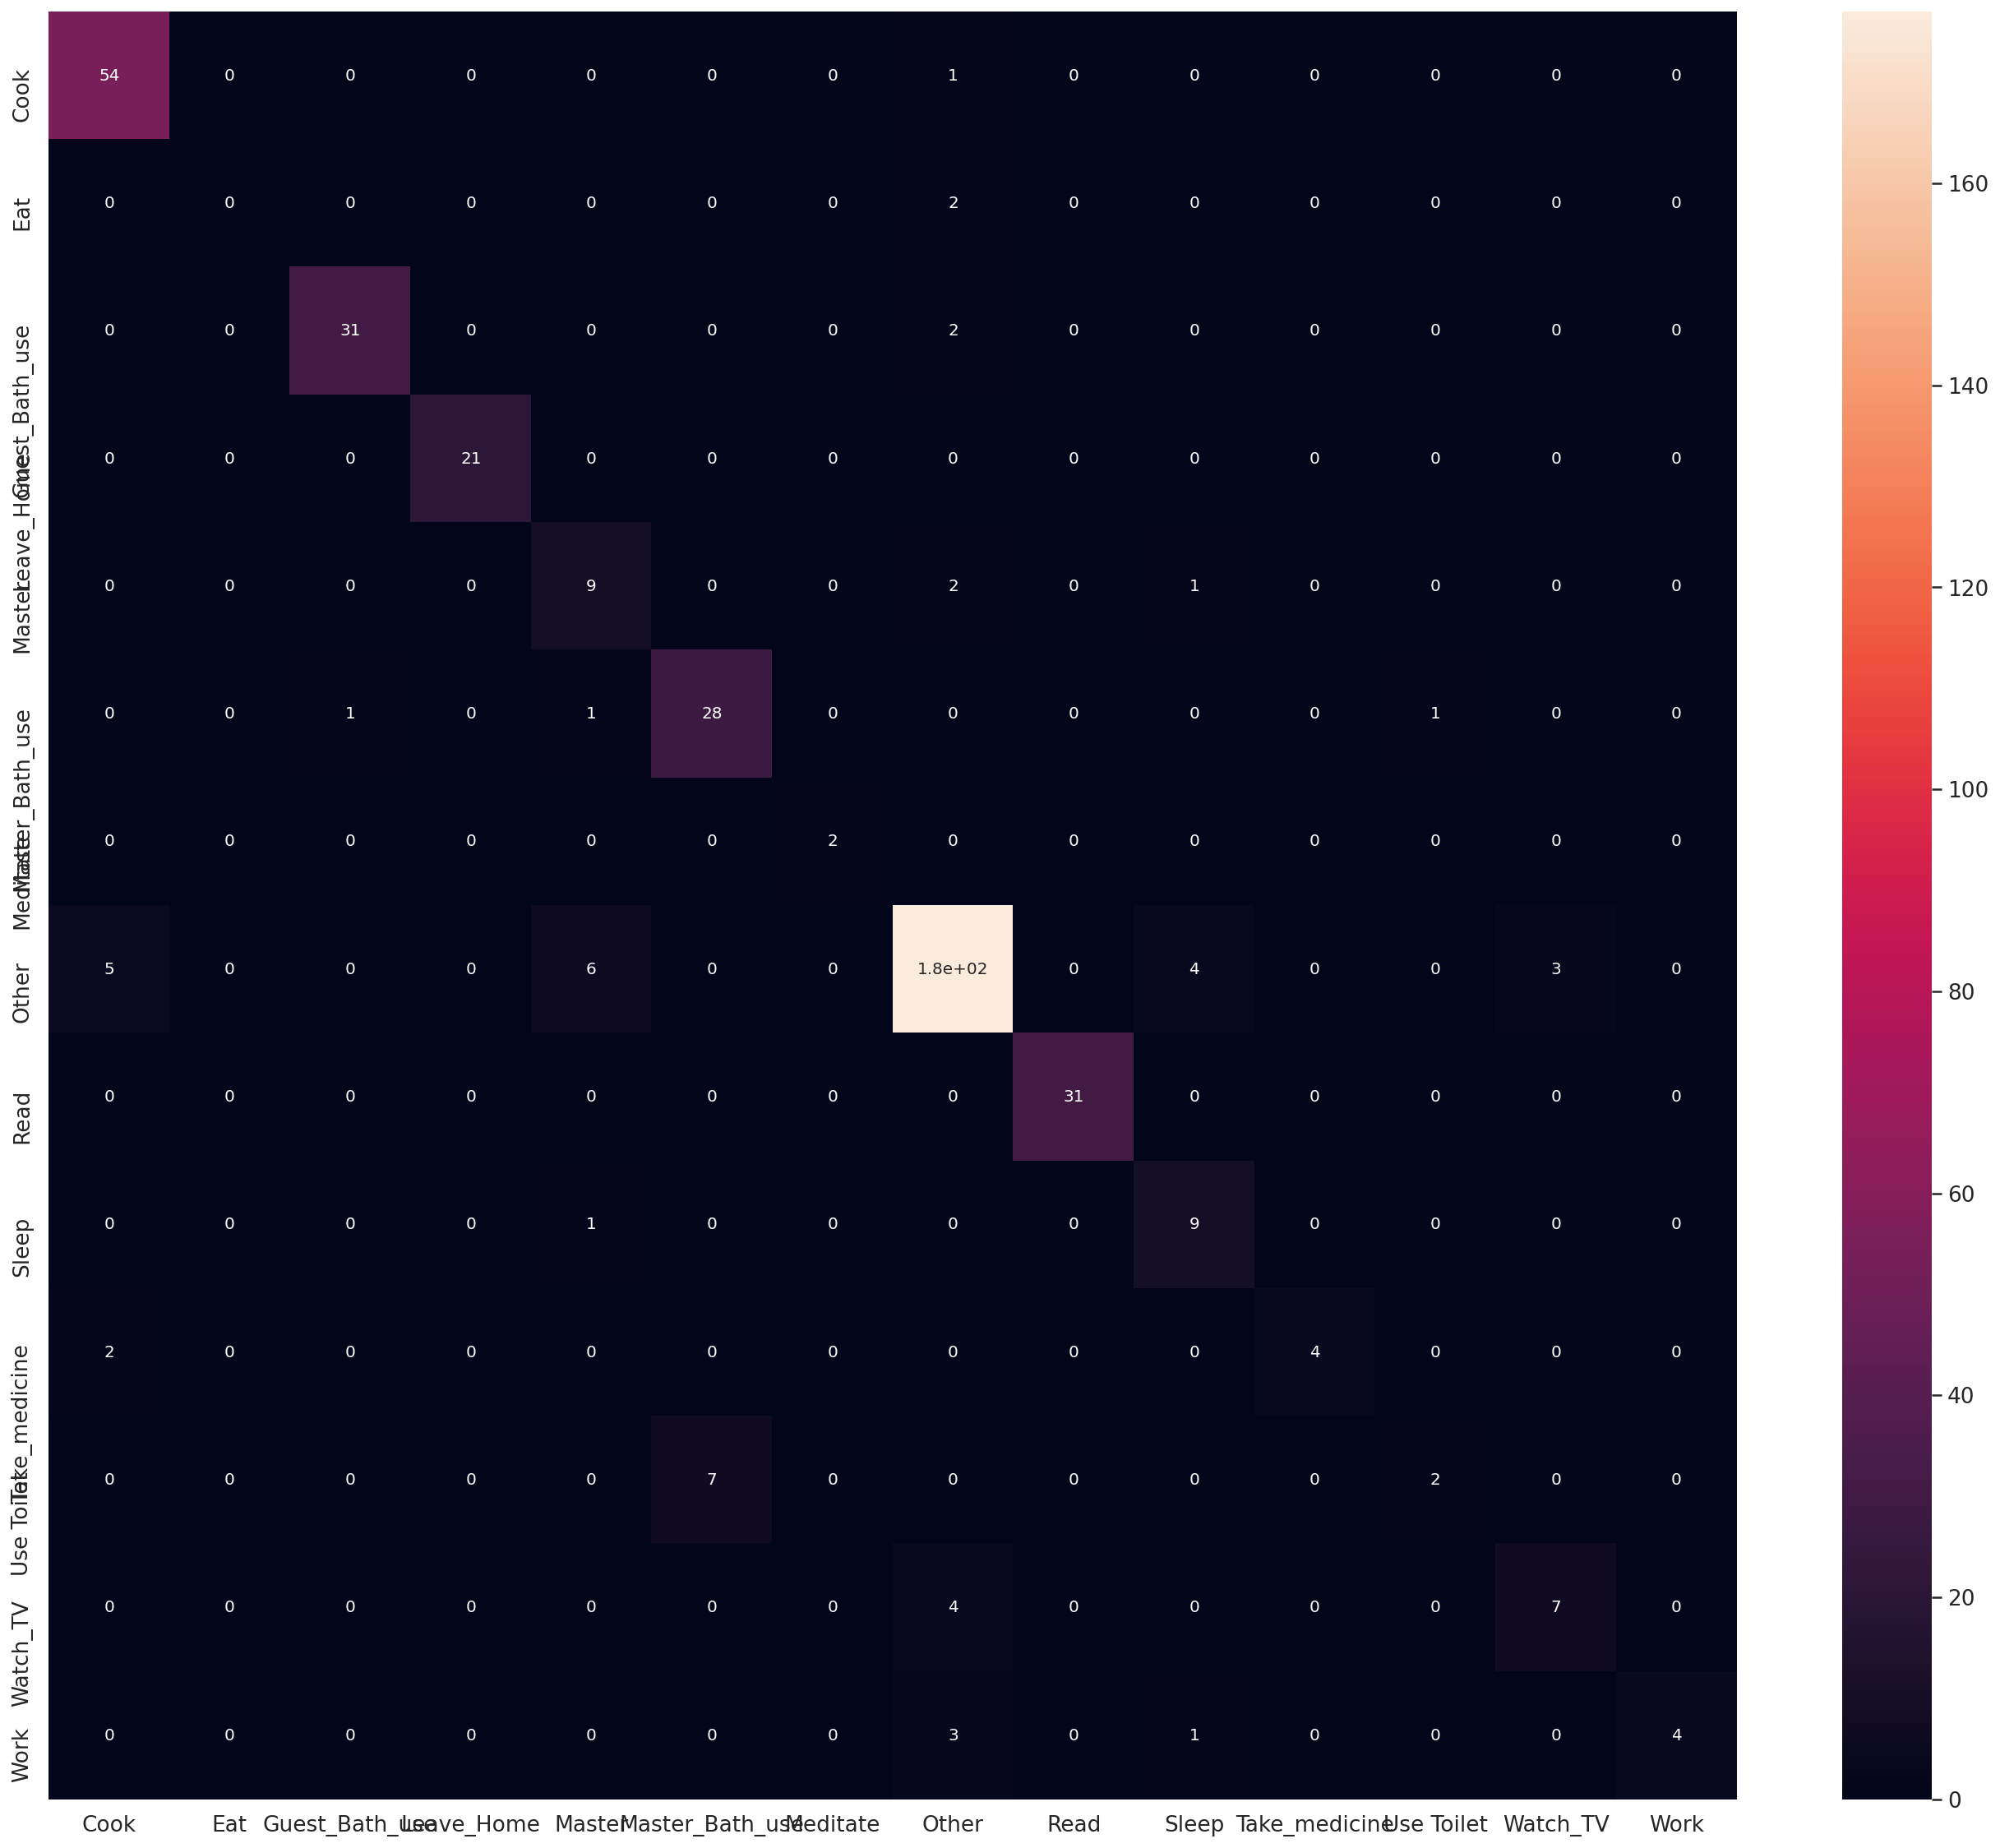

------------------------------------------------------------------------------------------------------------------------


In [ ]:
#GO
run(X, y, idx2act, model, 'biLSTM_EP1', 10)